# Solution for the second science case

In [2]:
#########################################
# Author: Eduardo Alberto Duarte Lacerda
# E-mail: dhubax@gmail.com
#########################################

# needed Python imports
# imports for data retrieve
import lsdb
import splusdata
from dask.distributed import Client
# imports for plot and calculation
import numpy as np
from matplotlib import pyplot as plt

# auxiliar functions and variables

# https://github.com/splus-collab/splus_filters for S-PLUS filters information
splus_bands = [
    'u', 'J0378', 'J0395', 'J0410', 'J0430', 
    'g', 'J0515', 'r', 'J0660', 'i', 'J0861', 'z',
]
# pivot wavelenght of S-PLUS filters 
splut_bands_pivot_wavelenghts = [
    3533.28, 3773.16, 3940.7, 4094.93, 
    4292.11, 4758.49, 5133.13, 6251.83, 
    6613.88, 7670.61, 8607.25, 8941.48
]
# List HiPSCat catalogs available on S-PLUS servers
splusdata.get_hipscats()

{'dr4_vacs': {'qso_z': {'hipscats': ['qso_z'], 'margins': ['qso_z_2arcsec']},
  'photozs': {'hipscats': ['photozs'], 'margins': ['photozs_2arcsec']},
  'calib_flag': {'hipscats': ['calib_flag'],
   'margins': ['calib_flag_2arcsec']},
  'sqg': {'hipscats': ['sqg'], 'margins': ['sqg_2arcsec']}},
 'sdr1': {'hipscats': ['shorts'], 'margins': ['shorts_2arcsec']},
 'dr4': {'hipscats': ['single', 'dual', 'psf'],
  'margins': ['psf_2arcsec', 'single_2arcsec', 'dual_2arcsec']}}

## S-PLUS Catalogs choice

In [4]:
# search for the full S-PLUS DR4/dual mode catalog
dr4dual_search = splusdata.get_hipscats('dr4/dual')

# Print all catalogs found with the pattern above
print(f'dr4/dual search: {dr4dual_search}')

# select the first catalog found
dr4dual_hipscat, dr4dual_margin_cache_hipscat = dr4dual_search[0]

# Search for the DR4 Star Galaxy Quasar VAC
'''
QSO/star/galaxy classification VAC: 
    https://splus.cloud/documentation/DR4?QSO/star/galaxy_classification
'''
dr4sqg_search = splusdata.get_hipscats('dr4/sqg')
# Print all catalogs found with the pattern above
print(f'dr4/sqg search: {dr4sqg_search}')
# select the first catalog found
dr4sqg_hipscat, dr4sqg_margin_cache_hipscat = dr4sqg_search[0]

# Create the columns list to retrieve only necessaries columns
'''/
We use here choose the magnitudes from 'PStotal' apperture mode.

Read mode about:
     https://splus.cloud/documentation/DR4?Photometry
'''
columns = ['ID', 'Field', 'RA', 'DEC', 'A', 'FLUX_RADIUS_70'] 
apperture = 'auto'
columns += [f'{b}_{apperture}' for b in splus_bands] 
columns += [f's2n_{b}_{apperture}' for b in splus_bands]

# filters 
SN_min = 5
filters = [(f's2n_{b}_{apperture}', '>', SN_min) for b in splus_bands]

dr4/dual search: [['https://splus.cloud/HIPS/catalogs/dr4/dual/', 'https://splus.cloud/HIPS/catalogs/dr4/dual_2arcsec/']]
dr4/sqg search: [['https://splus.cloud/HIPS/catalogs/dr4_vacs/sqg/sqg/', 'https://splus.cloud/HIPS/catalogs/dr4_vacs/sqg/sqg_2arcsec/']]


## Read catalogs using LSDB

### Start Dask client

In [5]:
# Start a Dask client for the parallel process used by lsdb
max_cpu = 8
max_mem = '6GB'
client = Client(n_workers=max_cpu, memory_limit=max_mem)
client

/home/lacerda/.pyenv/versions/dev/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43653 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:43653/status,
Dashboard: http://127.0.0.1:43653/status,Workers: 10
Total threads: 20,Total memory: 74.51 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44911,Workers: 10
Dashboard: http://127.0.0.1:43653/status,Total threads: 20
Started: Just now,Total memory: 74.51 GiB
Comm: tcp://127.0.0.1:34239,Total threads: 2
Dashboard: http://127.0.0.1:43227/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:46421,


### Read DR4/dual and QSO/star/galaxy catalogs

In [6]:
# Read more about the need of the margin cache server at:
#      https://lsdb.readthedocs.io/en/stable/tutorials/margins.html    
dr4dual_margin = lsdb.read_hipscat(dr4dual_margin_cache_hipscat)
dr4sqg_margin = lsdb.read_hipscat(dr4sqg_margin_cache_hipscat)

# Read DR4 dual HiPSCAT
dr4dual = lsdb.read_hipscat(
    dr4dual_hipscat,
    margin_cache=dr4dual_margin,
    # Read more about the available columns at:
    #      https://splus.cloud/documentation/DR4?Schemas,_tables_and_columns
    columns=columns,
    filters=filters,
)

# Read DR4 QSO/star/galaxy classification VAC HiPSCAT
# Here we filter only objects where the galaxy probability
# is greater than 80%
dr4sqg = lsdb.read_hipscat(
    dr4sqg_hipscat,
    margin_cache=dr4sqg_margin,
    filters=[('PROB_GAL', '>', 0.9)],
)

/home/lacerda/.pyenv/versions/dev/lib/python3.12/site-packages/hipscat/io/file_io/file_io.py:320: UserWarning: point_map.fits file written in RING ordering, due to https://github.com/astronomy-commons/hipscat/issues/271. Converting to NESTED.
  warnings.warn(


## Perform the crossmatch

In [7]:
# Do the crossmatch of both catalogs. 
identity_radius = 1  # arcsec
dr4dualsqg_crosmatch = dr4sqg.crossmatch(dr4dual, radius_arcsec=identity_radius)

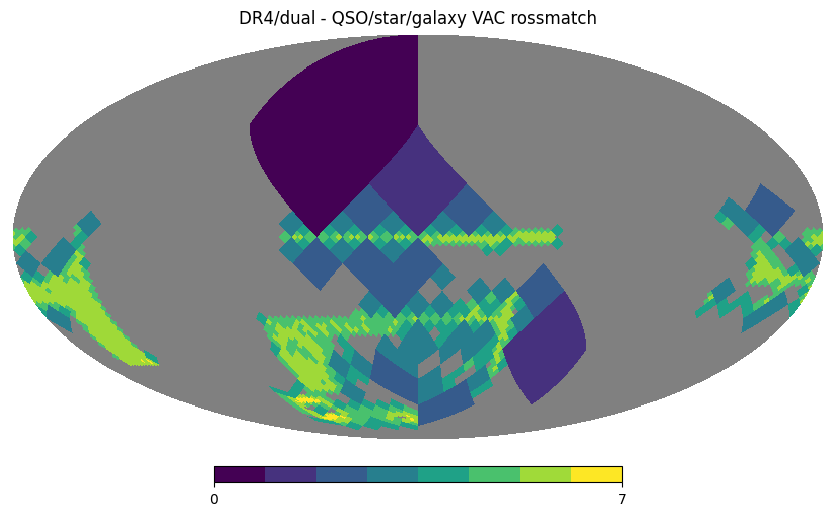

In [8]:
# You can use plot_pixels() to observe the catalog’s sky coverage map and 
# obtain information about its HEALPix distribution.
dr4dualsqg_crosmatch.plot_pixels('DR4/dual - QSO/star/galaxy VAC rossmatch')

## Search for objects using the crossmatch result table

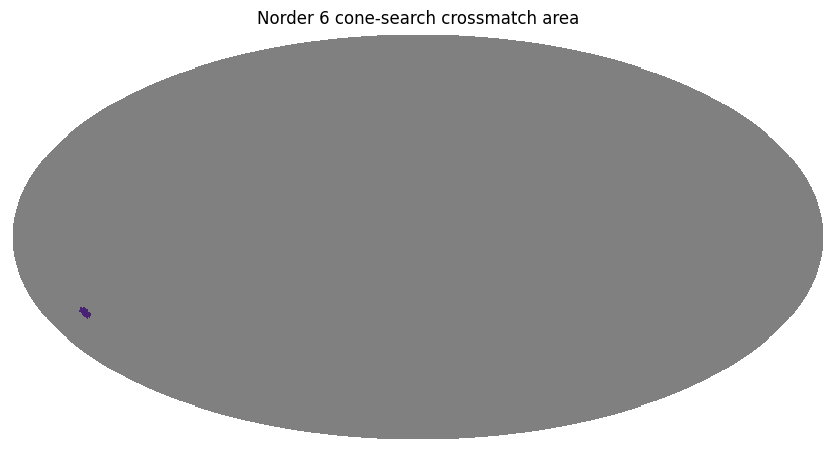

In [9]:
# Let's get the resultant table using a cone search:
cone_center_coord = (159.25, -27.5) # RA and DEC in degrees
cone_radius = 1.5*3600 # arcsec
objects_table_crossmatch = dr4dualsqg_crosmatch.cone_search(ra=cone_center_coord[0], dec=cone_center_coord[1], radius_arcsec=cone_radius)
objects_table_crossmatch.plot_pixels('cone-search crossmatch area')
objects_table = objects_table_crossmatch.compute()

<hr>

## Create plots

###  Spatial distribution plot

Text(0.5, 0, 'DEC')

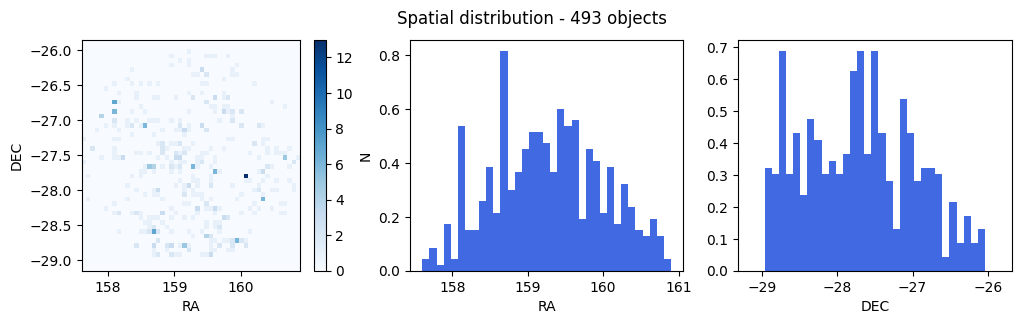

In [10]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_size_inches(12, 3)
N = len(objects_table)
f.suptitle(f'Spatial distribution - {N} objects')
ra = objects_table['RA_dual']
dec = objects_table['DEC_dual']
x = cone_radius/3600
ra_range = cone_center_coord[0]+np.array([-1.1*x, 1.1*x])
dec_range = cone_center_coord[1]+np.array([-1.1*x, 1.1*x])
_, _, _, im1 = ax1.hist2d(ra, dec, bins=50, range=[ra_range, dec_range], cmap='Blues')
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
cax = plt.colorbar(im1, ax=ax1)
cax.ax.set_ylabel('N')
ax2.hist(ra, bins=35, range=ra_range, density=True, color='royalblue', histtype='stepfilled')
ax2.set_xlabel('RA')
ax3.hist(dec, bins=35, range=dec_range, density=True, color='royalblue', histtype='stepfilled')
ax3.set_xlabel('DEC')

In [11]:
objects_table.

Index(['ID_sqg', 'RA_sqg', 'DEC_sqg', 'CLASS_sqg', 'model_flag_sqg',
       'PROB_QSO_sqg', 'PROB_STAR_sqg', 'PROB_GAL_sqg', 'Norder_sqg',
       'Dir_sqg', 'Npix_sqg', 'ID_dual', 'Field_dual', 'RA_dual', 'DEC_dual',
       'A_dual', 'FLUX_RADIUS_70_dual', 'u_auto_dual', 'J0378_auto_dual',
       'J0395_auto_dual', 'J0410_auto_dual', 'J0430_auto_dual', 'g_auto_dual',
       'J0515_auto_dual', 'r_auto_dual', 'J0660_auto_dual', 'i_auto_dual',
       'J0861_auto_dual', 'z_auto_dual', 's2n_u_auto_dual',
       's2n_J0378_auto_dual', 's2n_J0395_auto_dual', 's2n_J0410_auto_dual',
       's2n_J0430_auto_dual', 's2n_g_auto_dual', 's2n_J0515_auto_dual',
       's2n_r_auto_dual', 's2n_J0660_auto_dual', 's2n_i_auto_dual',
       's2n_J0861_auto_dual', 's2n_z_auto_dual', '_dist_arcsec'],
      dtype='object')

(array([106., 129., 110.,  47.,  28.,  20.,  14.,   7.,   7.,   4.,   4.,
          2.,   3.,   0.,   1.,   2.,   0.,   0.,   0.,   1.,   1.,   0.,
          1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.]),
 array([0.0002717 , 0.00090168, 0.00153166, 0.00216164, 0.00279162,
        0.0034216 , 0.00405158, 0.00468156, 0.00531153, 0.00594151,
        0.00657149, 0.00720147, 0.00783145, 0.00846143, 0.00909141,
        0.00972139, 0.01035137, 0.01098135, 0.01161133, 0.01224131,
        0.01287129, 0.01350127, 0.01413125, 0.

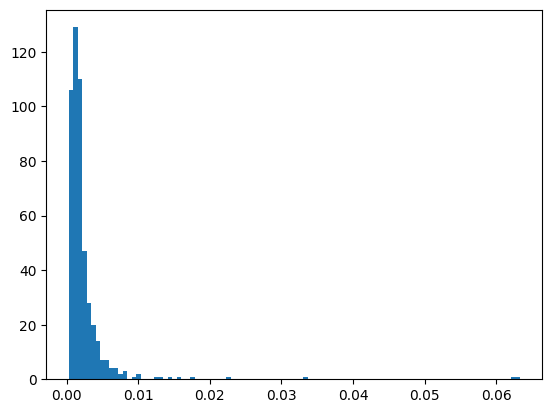

In [19]:
plt.hist(objects_table['A_dual'], bins=100)

In [27]:
objects_table.loc[objects_table['A_dual'] > 0.005]

,ID_sqg,RA_sqg,DEC_sqg,CLASS_sqg,model_flag_sqg,PROB_QSO_sqg,PROB_STAR_sqg,PROB_GAL_sqg,Norder_sqg,Dir_sqg,...,s2n_J0410_auto_dual,s2n_J0430_auto_dual,s2n_g_auto_dual,s2n_J0515_auto_dual,s2n_r_auto_dual,s2n_J0660_auto_dual,s2n_i_auto_dual,s2n_J0861_auto_dual,s2n_z_auto_dual,_dist_arcsec
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
10911812383865307136,DR4_3_HYDRA-0045_0015001,159.148299,-28.766096,2.0,1,0.0,0.0,1.0,6,30000,...,21.619558,15.002071,64.916862,21.800867,17.567272,13.21943,25.099438,8.575005,6.184358,0.0
10911823926132736000,DR4_3_HYDRA-0045_0007856,159.476563,-28.661648,2.0,1,0.0,0.05,0.95,6,30000,...,32.645432,35.342834,154.35997,51.742329,15.727875,121.645424,112.129929,48.583092,48.904182,0.0
10912000041392537600,DR4_3_HYDRA-0046_0034046,160.353791,-28.133933,2.0,0,0.0,0.05,0.95,6,30000,...,22.0963,20.059551,12.967585,26.736393,14.381598,9.689344,11.982569,6.219392,10.712258,0.0
10912003456885587968,DR4_3_HYDRA-0046_0035059,160.307242,-28.124703,2.0,0,0.0,0.0,1.0,6,30000,...,12.806403,12.928443,13.610144,16.128347,14.329757,9.627378,12.751101,5.675528,9.947079,0.0
10912124702260461568,DR4_3_HYDRA-0045_0049794,159.853825,-27.912481,2.0,0,0.0,0.02,0.98,6,30000,...,25.793036,29.247875,124.89856,38.923351,33.793163,18.96792,10.870987,26.863544,6.121912,0.0
10912140204198330368,DR4_3_HYDRA-0045_0070191,160.071146,-27.776828,2.0,0,0.0,0.0,1.0,6,30000,...,36.233677,62.149132,536.210571,326.970367,644.84082,188.178604,736.11853,344.970673,10.015684,0.0
10915179288420417536,DR4_3_HYDRA-0046_0064570,160.682437,-27.518942,2.0,0,0.0,0.0,1.0,6,30000,...,127.100288,90.847733,7.628568,199.882111,15.879729,13.717548,10.247392,14.79371,10.033846,0.0
10935123205064491008,DR4_3_HYDRA-0045_0016356,158.718696,-28.583926,2.0,0,0.0,0.03,0.97,6,30000,...,1363.173584,1368.997925,32.253803,1904.026978,12.305601,8.951736,17.922367,1653.403687,20.553751,0.0
10935123235032793088,DR4_3_HYDRA-0045_0019354,158.705827,-28.588633,2.0,1,0.0,0.01,0.99,6,30000,...,717.330383,731.484985,25.118254,1052.670288,10.570748,8.128528,15.750502,965.167175,18.100168,0.0


In [25]:
from astropy.coordinates import SkyCoord
c = SkyCoord(ra='10h37m02.5s', dec='27d33m56s')

In [26]:
c.ra.value, c.dec.value

(159.26041666666666, 27.565555555555555)

### Galaxies CMD plot (coloured by J0660 mag)

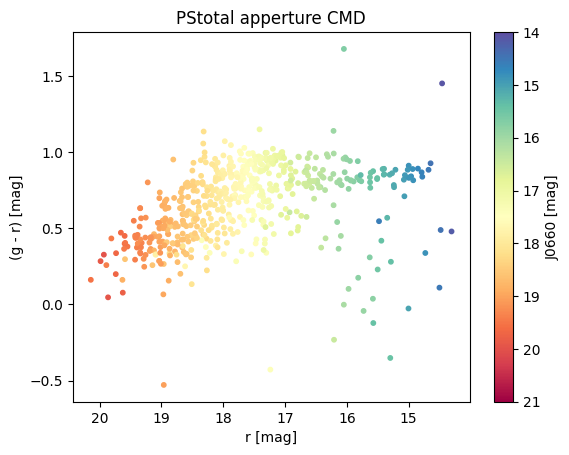

In [9]:
x = objects_table[f'r_{apperture}_dual']
y = objects_table[f'g_{apperture}_dual'] - objects_table[f'r_{apperture}_dual']
z = objects_table[f'J0660_{apperture}_dual']

# keep magnitudes between 21 and 14
mask = np.ones(x.shape, dtype='bool')
for band in ['r', 'g', 'J0660']:
    mask = np.bitwise_and(mask, objects_table[f'{band}_{apperture}_dual'] > 14)
    mask = np.bitwise_and(mask, objects_table[f'{band}_{apperture}_dual'] < 21)

f, ax = plt.subplots()
im = ax.scatter(x[mask], y[mask], c=z[mask], s=10, cmap='Spectral_r', vmin=14, vmax=21)
ax.set_title(f'{apperture} apperture CMD')
cax = plt.colorbar(im, ax=ax)
cax.ax.set_ylabel('J0660 [mag]')
cax.ax.invert_yaxis()
ax.set_xlabel(f'r [mag]')
ax.set_ylabel(f'(g - r) [mag]')
ax.invert_xaxis()

# 12-bands magnitudes for objects

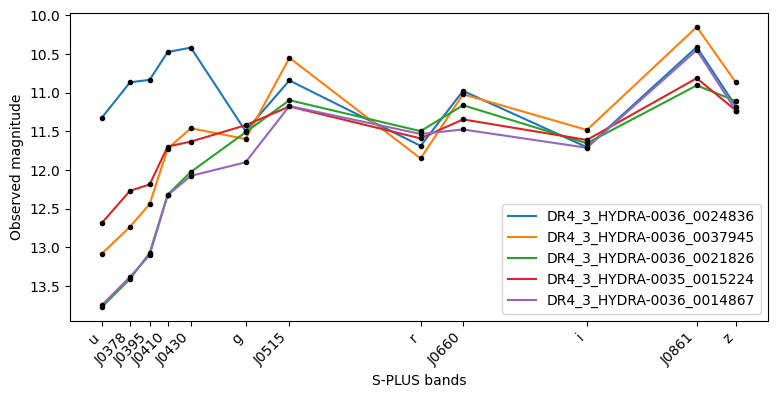

In [10]:
# sort table by J0660 mag values and get the 5 brightest objects
sorted_objects_table = objects_table.sort_values(by=f'J0660_{apperture}_dual').head(5)
# Filter only magnitudes to plot
pd_filter = [f'{band}_{apperture}_dual' for band in splus_bands]
objs_mags = sorted_objects_table[pd_filter].T

f, ax = plt.subplots()
f.set_size_inches(9, 4)
ax.plot(splut_bands_pivot_wavelenghts, objs_mags, label=sorted_objects_table['ID_sqg'])
ax.plot(splut_bands_pivot_wavelenghts, objs_mags, '.k')
ax.set_xticks(splut_bands_pivot_wavelenghts)
ax.set_xticklabels(splus_bands, rotation=45, ha='right')
ax.set_xlabel('S-PLUS bands')
ax.set_ylabel('Observed magnitude')
ax.legend()
ax.invert_yaxis()

In [11]:
plt.close('all')